In [1]:
# Written by Margot Yuan (AMSC)
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})

In [2]:
def ExactSolution(x,y):
    # e^{-x}(x+y^3)
    # return torch.exp(-x)*(x+y.pow(3))
    return (y**2)*torch.sin(torch.pi*x)

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

tensor([[0.1250, 0.1250],
        [0.1250, 0.2500],
        [0.1250, 0.3750],
        [0.1250, 0.5000],
        [0.1250, 0.6250],
        [0.1250, 0.7500],
        [0.1250, 0.8750],
        [0.2500, 0.1250],
        [0.2500, 0.2500],
        [0.2500, 0.3750],
        [0.2500, 0.5000],
        [0.2500, 0.6250],
        [0.2500, 0.7500],
        [0.2500, 0.8750],
        [0.3750, 0.1250],
        [0.3750, 0.2500],
        [0.3750, 0.3750],
        [0.3750, 0.5000],
        [0.3750, 0.6250],
        [0.3750, 0.7500],
        [0.3750, 0.8750],
        [0.5000, 0.1250],
        [0.5000, 0.2500],
        [0.5000, 0.3750],
        [0.5000, 0.5000],
        [0.5000, 0.6250],
        [0.5000, 0.7500],
        [0.5000, 0.8750],
        [0.6250, 0.1250],
        [0.6250, 0.2500],
        [0.6250, 0.3750],
        [0.6250, 0.5000],
        [0.6250, 0.6250],
        [0.6250, 0.7500],
        [0.6250, 0.8750],
        [0.7500, 0.1250],
        [0.7500, 0.2500],
        [0.7500, 0.3750],
        [0.7

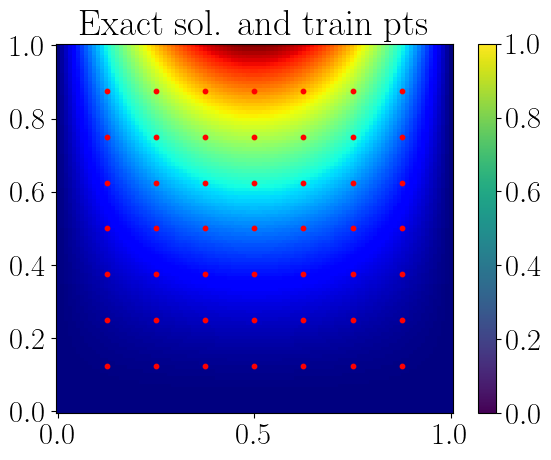

In [4]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
# plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.pcolormesh(xtest_grid,ytest_grid,sol_exact,cmap = 'jet')
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [5]:
# x = np.linspace(0,1,100)
# y = np.linspace(0,1,100)
# x_train, y_train = np.meshgrid(x,y)
# train_data = torch.tensor(np.hstack((x_train.ravel()[:,None],y_train.ravel()[:,None])),\
#                          dtype = torch.float32)
# train_data.requires_grad_(True)

In [6]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
        
    def forward(self, xb):
        act = nn.Tanh()
#         act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = act(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

# ...existing code...
def SolutionModel(x,y,nn_output,NN):
    B = y*(2*torch.sin(np.pi*x))
    nn_output_x1 = NN(torch.cat((x.unsqueeze(-1), torch.ones_like(x).unsqueeze(-1)), dim=-1))
    
    # Calculate the partial derivative of NN(x,1) with respect to y
    ones = torch.ones_like(x, requires_grad=True)  # Create a tensor of ones for y=1
    nn_output_x1 = NN(torch.cat((x.unsqueeze(-1), ones.unsqueeze(-1)), dim=-1))
    grad_y_x1 = torch.autograd.grad(nn_output_x1, ones, grad_outputs=torch.ones_like(nn_output_x1), create_graph=True)[0]
    
    sol = B + x*(1-x)*y*(nn_output.squeeze() - nn_output_x1.squeeze() - grad_y_x1.squeeze())
    return sol

def Solution(x,y,nn_output,NN):
    # \Psi(x,y) = B(x,y) + x(1-x)y\left[NN(x,y;w)-NN(x,1;w)-(\frac{\partial NN(x,1;w)}{\partial y})\right]
    # where
    # B(x,y) = y\left\{2\sin(\pi x)-\left\[(1-x)2\sin(0)+x2\sin(\pi 1)\right\]\right\}

    B = y*(2*torch.sin(np.pi*x))

    # Calculate NN(x,1;w)
    x_unsqueeze = x.unsqueeze(-1)
    y_ones = torch.ones_like(x).unsqueeze(-1)
    nn_output_x1 = NN(torch.cat((x_unsqueeze, y_ones), dim=-1))

    # Calculate the partial derivative of NN(x,1) with respect to y
    y_ones = torch.ones_like(x, requires_grad=True)  # Create a tensor of ones for y=1
    nn_output_x1_grad = NN(torch.cat((x.unsqueeze(-1), y_ones.unsqueeze(-1)), dim=-1))
    grad_y_x1 = torch.autograd.grad(nn_output_x1_grad, y_ones, grad_outputs=torch.ones_like(nn_output_x1_grad), create_graph=True)[0]

    sol = B + x*(1-x)*y*(nn_output.squeeze() - nn_output_x1.squeeze() - grad_y_x1.squeeze())
    return sol

def RHS(x,y):
    return (2-torch.pi**2 * y**2)*torch.sin(np.pi*x)


In [7]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [8]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [9]:
losses = []
for epoch in range(2000):
    TOL = 1.0e-6
    for X,y in train_dl:
        optimizer.zero_grad()
        nn_approx = model(X)
        Q = SolutionModel(X[:,0],X[:,1],nn_approx,model)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])
        
        loss = loss_fn(lhs,y)
        losses.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break

loss at epoch 1 is 51.146156311035156
loss at epoch 101 is 0.3045639097690582
loss at epoch 201 is 0.181406170129776
loss at epoch 301 is 0.15632101893424988
loss at epoch 401 is 0.1256849765777588
loss at epoch 501 is 0.09365478157997131
loss at epoch 601 is 0.06780955195426941
loss at epoch 701 is 0.044742923229932785
loss at epoch 801 is 0.026747271418571472
loss at epoch 901 is 0.01609526202082634
loss at epoch 1001 is 0.010682333260774612
loss at epoch 1101 is 0.007955798879265785
loss at epoch 1201 is 0.006479659117758274
loss at epoch 1301 is 0.005595076829195023
loss at epoch 1401 is 0.0049936724826693535
loss at epoch 1501 is 0.004531920421868563
loss at epoch 1601 is 0.004146920051425695
loss at epoch 1701 is 0.0038131969049572945
loss at epoch 1801 is 0.003520681755617261
loss at epoch 1901 is 0.003264556173235178


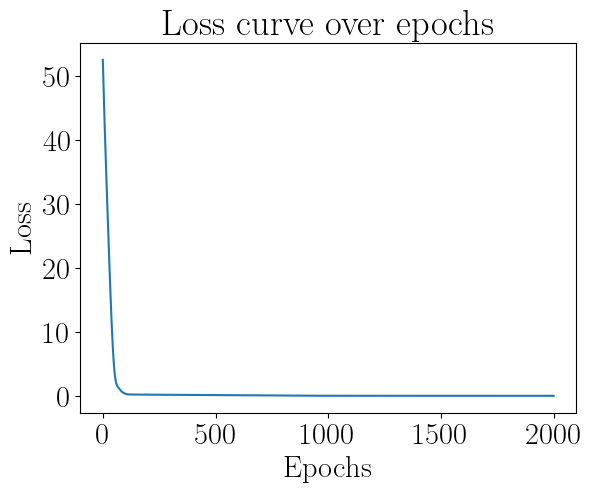

In [12]:
plt.plot(losses)
plt.title("Loss curve over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Max error =  0.003915906
Mean error =  0.00071515853
RMS error =  0.0011148567


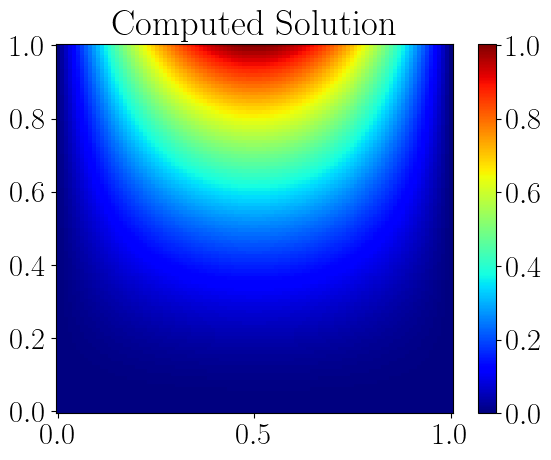

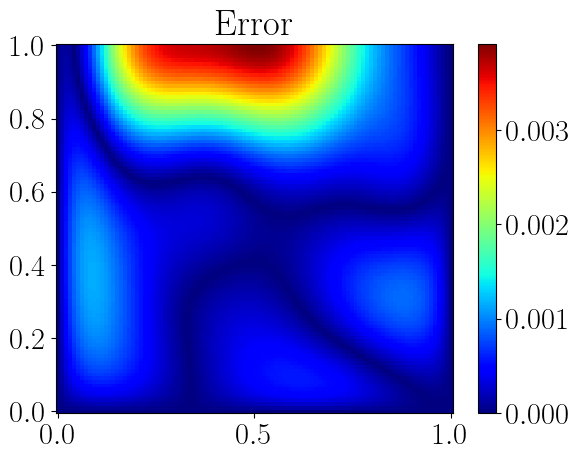

In [11]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        pt = torch.tensor([[xtest_grid[i,j],ytest_grid[i,j]]])
        sol_test[i,j] = Solution(xtest_grid[i,j],ytest_grid[i,j],model(pt),model)
plt.figure()
# plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.pcolormesh(xtest_grid,ytest_grid,sol_test.detach().numpy(),cmap='jet')
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.pcolormesh(xtest_grid,ytest_grid,error,cmap='jet')
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))